# Podcast Listening Time Prediction - Exploratory Data Analysis

This notebook explores the Podcast Listening Time Prediction dataset from the Kaggle competition. The goal is to predict how long listeners will tune in to a podcast episode based on various features.

## 1. Setup and Data Loading

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# For visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# For modeling
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb

# Set visualization style
sns.set(style='whitegrid')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the datasets
train_path = '../Datasets/train.csv'
test_path = '../Datasets/test.csv'
sample_submission_path = '../Datasets/sample_submission.csv'

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_submission_path)

# Display basic information
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Training set shape: (750000, 12)
Test set shape: (250000, 11)
Sample submission shape: (250000, 2)


## 2. Data Overview and Initial Inspection

In [3]:
# Display first few rows of training data
train.head()

id     Podcast_Name Episode_Title  Episode_Length_minutes       Genre  \
0   0  Mystery Matters    Episode 98                     NaN  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   
3   3   Digital Digest    Episode 45                   67.17  Technology   
4   4      Mind & Body    Episode 86                  110.51      Health   

   Host_Popularity_percentage Publication_Day Publication_Time  \
0                       74.81        Thursday            Night   
1                       66.95        Saturday        Afternoon   
2                       69.97         Tuesday          Evening   
3                       57.22          Monday          Morning   
4                       80.07          Monday        Afternoon   

   Guest_Popularity_percentage  Number_of_Ads Episode_Sentiment  \
0                          NaN            0.0          Positive   
1                        75.95            2.0          Negative   
2                         8.97            0.0          Negative   
3                        78.70            2.0          Positive   
4                        58.68            3.0           Neutral   

   Listening_Time_minutes  
0                31.41998  
1                88.01241  
2                44.92531  
3                46.27824  
4                75.61031

In [4]:
# Display first few rows of test data
test.head()

id         Podcast_Name Episode_Title  Episode_Length_minutes  \
0  750000  Educational Nuggets    Episode 73                   78.96   
1  750001          Sound Waves    Episode 23                   27.87   
2  750002        Joke Junction    Episode 11                   69.10   
3  750003        Comedy Corner    Episode 73                  115.39   
4  750004         Life Lessons    Episode 50                   72.32   

       Genre  Host_Popularity_percentage Publication_Day Publication_Time  \
0  Education                       38.11        Saturday          Evening   
1      Music                       71.29          Sunday          Morning   
2     Comedy                       67.89          Friday          Evening   
3     Comedy                       23.40          Sunday          Morning   
4  Lifestyle                       58.10       Wednesday          Morning   

   Guest_Popularity_percentage  Number_of_Ads Episode_Sentiment  
0                        53.33            1.0           Neutral  
1                          NaN            0.0           Neutral  
2                        97.51            0.0          Positive  
3                        51.75            2.0          Positive  
4                        11.30            2.0           Neutral

In [5]:
# Check data types and basic statistics
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           750000 non-null  int64  
 1   Podcast_Name                 750000 non-null  object 
 2   Episode_Title                750000 non-null  object 
 3   Episode_Length_minutes       662907 non-null  float64
 4   Genre                        750000 non-null  object 
 5   Host_Popularity_percentage   750000 non-null  float64
 6   Publication_Day              750000 non-null  object 
 7   Publication_Time             750000 non-null  object 
 8   Guest_Popularity_percentage  603970 non-null  float64
 9   Number_of_Ads                749999 non-null  float64
 10  Episode_Sentiment            750000 non-null  object 
 11  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 68.7+ MB


In [6]:
# Statistical summary of numerical features
train.describe()

id  Episode_Length_minutes  Host_Popularity_percentage  \
count  750000.000000           662907.000000               750000.000000   
mean   374999.500000               64.504738                   59.859901   
std    216506.495284               32.969603                   22.873098   
min         0.000000                0.000000                    1.300000   
25%    187499.750000               35.730000                   39.410000   
50%    374999.500000               63.840000                   60.050000   
75%    562499.250000               94.070000                   79.530000   
max    749999.000000              325.240000                  119.460000   

       Guest_Popularity_percentage  Number_of_Ads  Listening_Time_minutes  
count                603970.000000  749999.000000           750000.000000  
mean                     52.236449       1.348855               45.437406  
std                      28.451241       1.151130               27.138306  
min                       0.000000       0.000000                0.000000  
25%                      28.380000       0.000000               23.178350  
50%                      53.580000       1.000000               43.379460  
75%                      76.600000       2.000000               64.811580  
max                     119.910000     103.910000              119.970000

In [7]:
# Check if there are any duplicate rows in train
print(f"Number of duplicate rows in train: {train.duplicated().sum()}")

Number of duplicate rows in train: 0


In [8]:
# Check if there are any duplicate rows in test
print(f"Number of duplicate rows in test: {test.duplicated().sum()}")

Number of duplicate rows in test: 0


## 3. Missing Value Analysis

In [9]:
# Check for missing values in training set
missing_train = train.isnull().sum().sort_values(ascending=False)
missing_train_percent = (train.isnull().sum() / train.shape[0] * 100).sort_values(ascending=False)
missing_train_df = pd.concat([missing_train, missing_train_percent], axis=1, keys=['Total', 'Percent'])
print("Missing values in training set:")
missing_train_df[missing_train_df['Total'] > 0]

Missing values in training set:


Total    Percent
Guest_Popularity_percentage  146030  19.470667
Episode_Length_minutes        87093  11.612400
Number_of_Ads                     1   0.000133

In [10]:
# Check for missing values in test set
missing_test = test.isnull().sum().sort_values(ascending=False)
missing_test_percent = (test.isnull().sum() / test.shape[0] * 100).sort_values(ascending=False)
missing_test_df = pd.concat([missing_test, missing_test_percent], axis=1, keys=['Total', 'Percent'])
print("Missing values in test set:")
missing_test_df[missing_test_df['Total'] > 0]

Missing values in test set:


Total  Percent
Guest_Popularity_percentage  48832  19.5328
Episode_Length_minutes       28736  11.4944

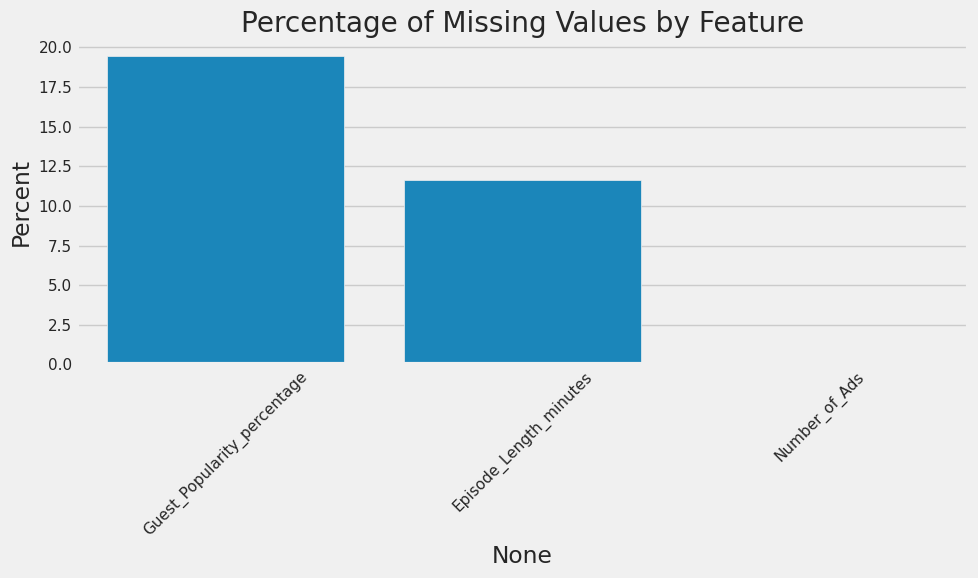

In [11]:
# Visualize missing values
plt.figure(figsize=(10, 6))
plt.title('Percentage of Missing Values by Feature')
sns.barplot(x=missing_train_df[missing_train_df['Total'] > 0].index, 
            y=missing_train_df[missing_train_df['Total'] > 0]['Percent'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Exploratory Data Analysis (EDA)

### 4.1 Target Variable Analysis

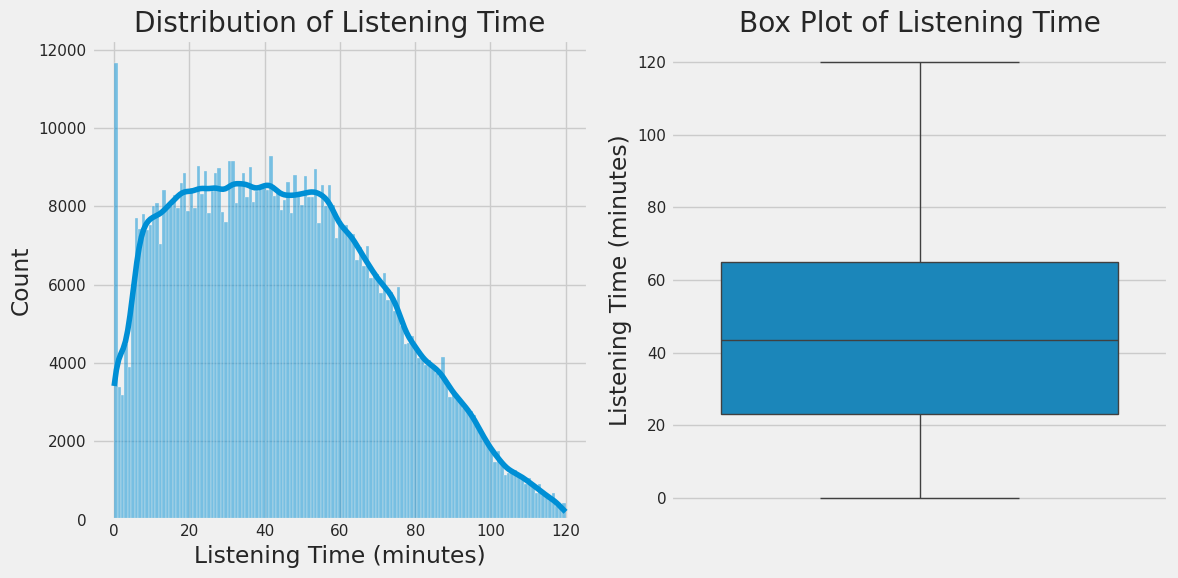

count    750000.000000
mean         45.437406
std          27.138306
min           0.000000
25%          23.178350
50%          43.379460
75%          64.811580
max         119.970000
Name: Listening_Time_minutes, dtype: float64


In [12]:
# Analyze the distribution of the target variable
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(train['Listening_Time_minutes'], kde=True)
plt.title('Distribution of Listening Time')
plt.xlabel('Listening Time (minutes)')

# Box plot
plt.subplot(1, 2, 2)
sns.boxplot(y=train['Listening_Time_minutes'])
plt.title('Box Plot of Listening Time')
plt.ylabel('Listening Time (minutes)')

plt.tight_layout()
plt.show()

# Basic statistics of target variable
print(train['Listening_Time_minutes'].describe())

In [13]:
# Check if there are any outliers in the target variable
Q1 = train['Listening_Time_minutes'].quantile(0.25)
Q3 = train['Listening_Time_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train['Listening_Time_minutes'] < lower_bound) | 
                 (train['Listening_Time_minutes'] > upper_bound)]

print(f"Number of outliers in target variable: {len(outliers)}")
print(f"Percentage of outliers: {len(outliers) / len(train) * 100:.2f}%")

Number of outliers in target variable: 0
Percentage of outliers: 0.00%


### 4.2 Feature Analysis - Categorical Variables

In [14]:
# Identify categorical columns
categorical_cols = [col for col in train.columns if train[col].dtype == 'object']
print(f"Categorical columns: {categorical_cols}")

# Count unique values in each categorical column
for col in categorical_cols:
    print(f"\n{col} - {train[col].nunique()} unique values:")
    print(train[col].value_counts().sort_values(ascending=False).head(10))

Categorical columns: ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

Podcast_Name - 48 unique values:
Podcast_Name
Tech Talks           22847
Sports Weekly        20053
Funny Folks          19635
Tech Trends          19549
Fitness First        19488
Business Insights    19480
Style Guide          19364
Game Day             19272
Melody Mix           18889
Criminal Minds       17735
Name: count, dtype: int64

Episode_Title - 100 unique values:
Episode_Title
Episode 71    10515
Episode 62    10373
Episode 31    10292
Episode 61     9991
Episode 69     9864
Episode 23     9762
Episode 63     9743
Episode 81     9741
Episode 64     9686
Episode 72     9554
Name: count, dtype: int64

Genre - 10 unique values:
Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
Name: count, dtype: int6

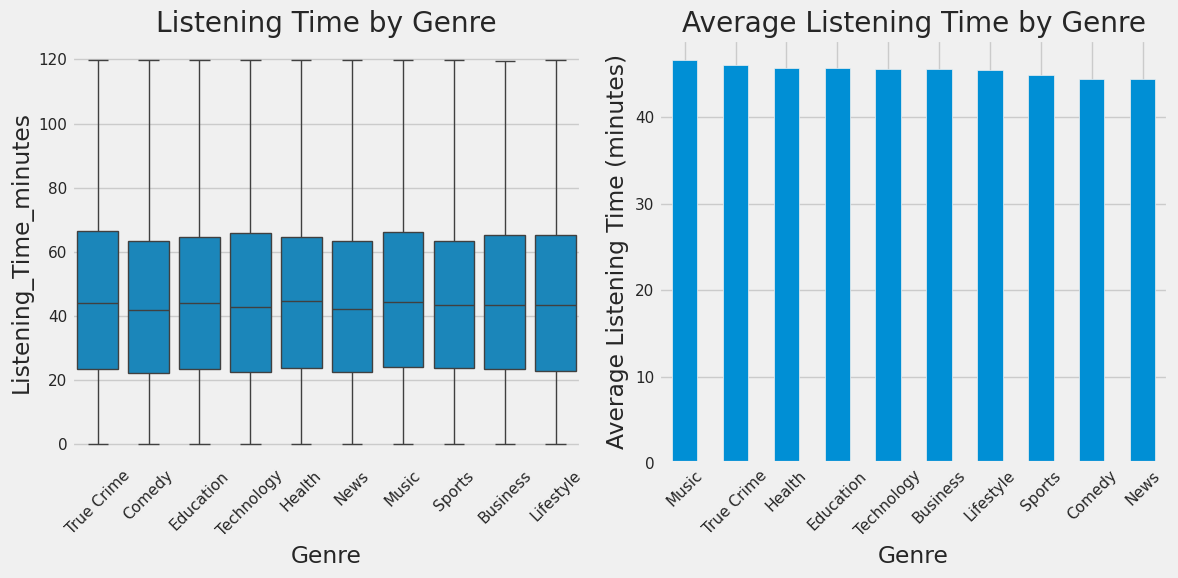

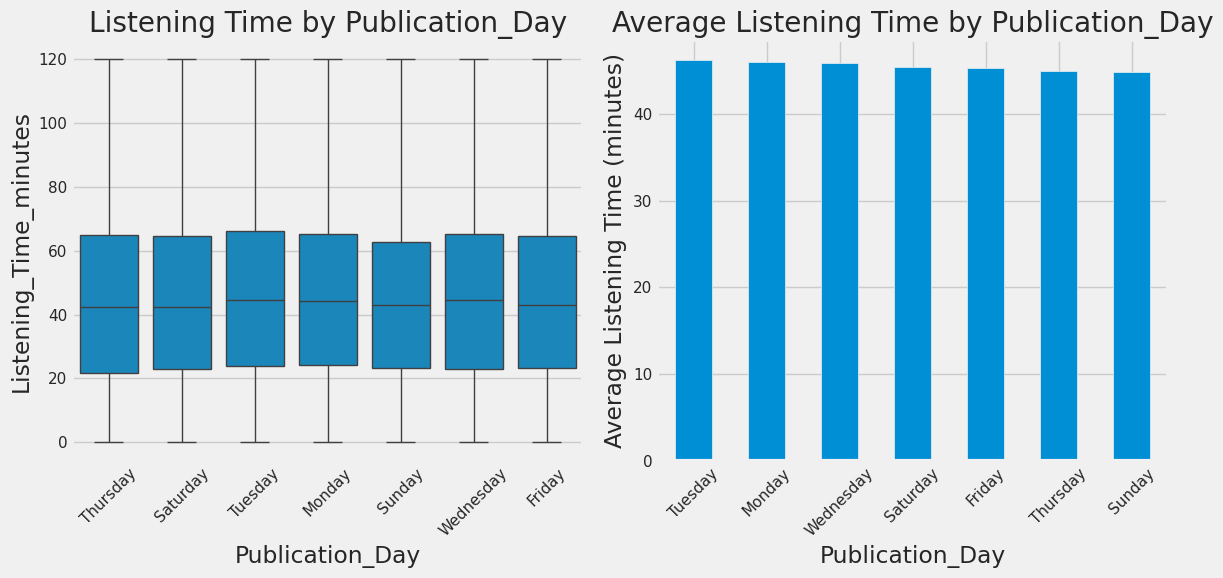

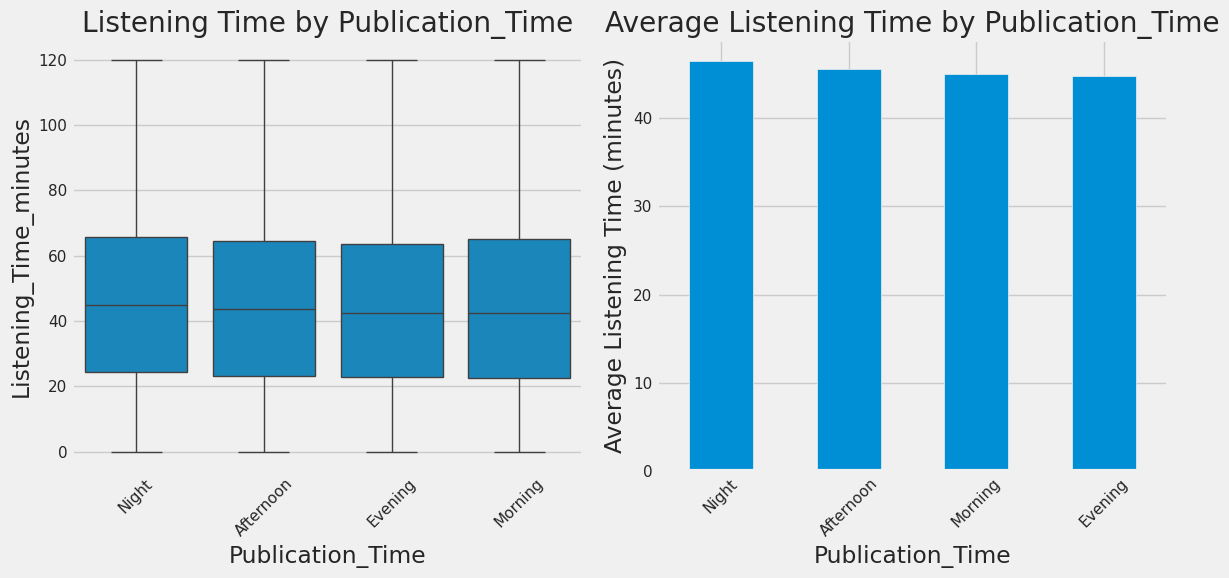

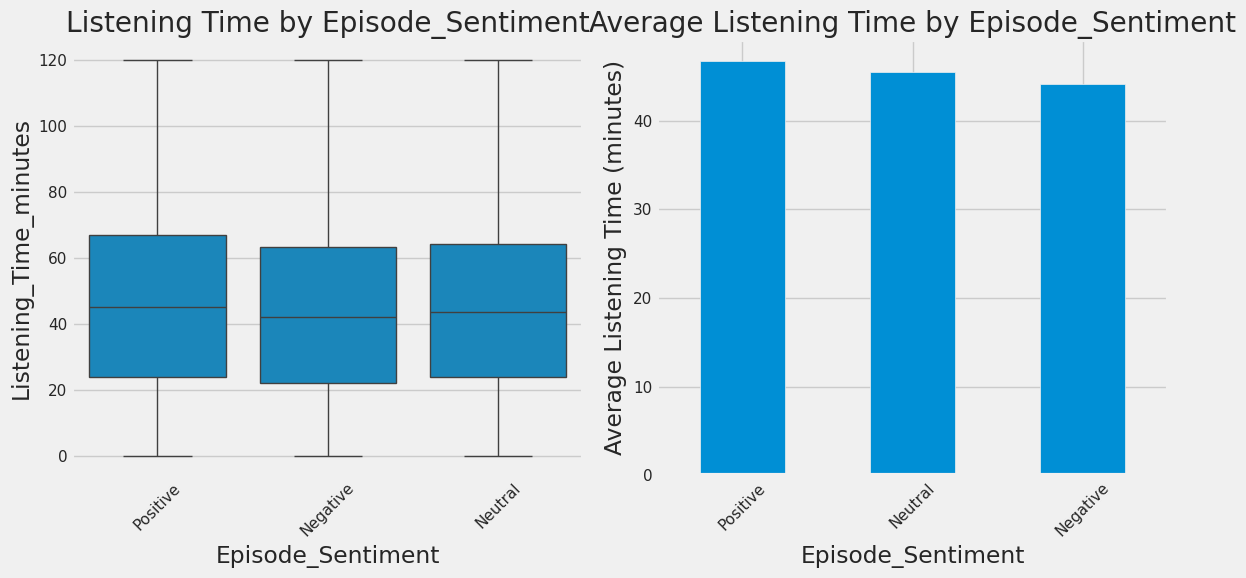

In [15]:
# Visualize relationship between categorical features and target variable
for col in ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']:
    plt.figure(figsize=(12, 6))
    
    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=col, y='Listening_Time_minutes', data=train)
    plt.title(f'Listening Time by {col}')
    plt.xticks(rotation=45)
    
    # Bar plot for average listening time
    plt.subplot(1, 2, 2)
    train.groupby(col)['Listening_Time_minutes'].mean().sort_values(ascending=False).plot(kind='bar')
    plt.title(f'Average Listening Time by {col}')
    plt.ylabel('Average Listening Time (minutes)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

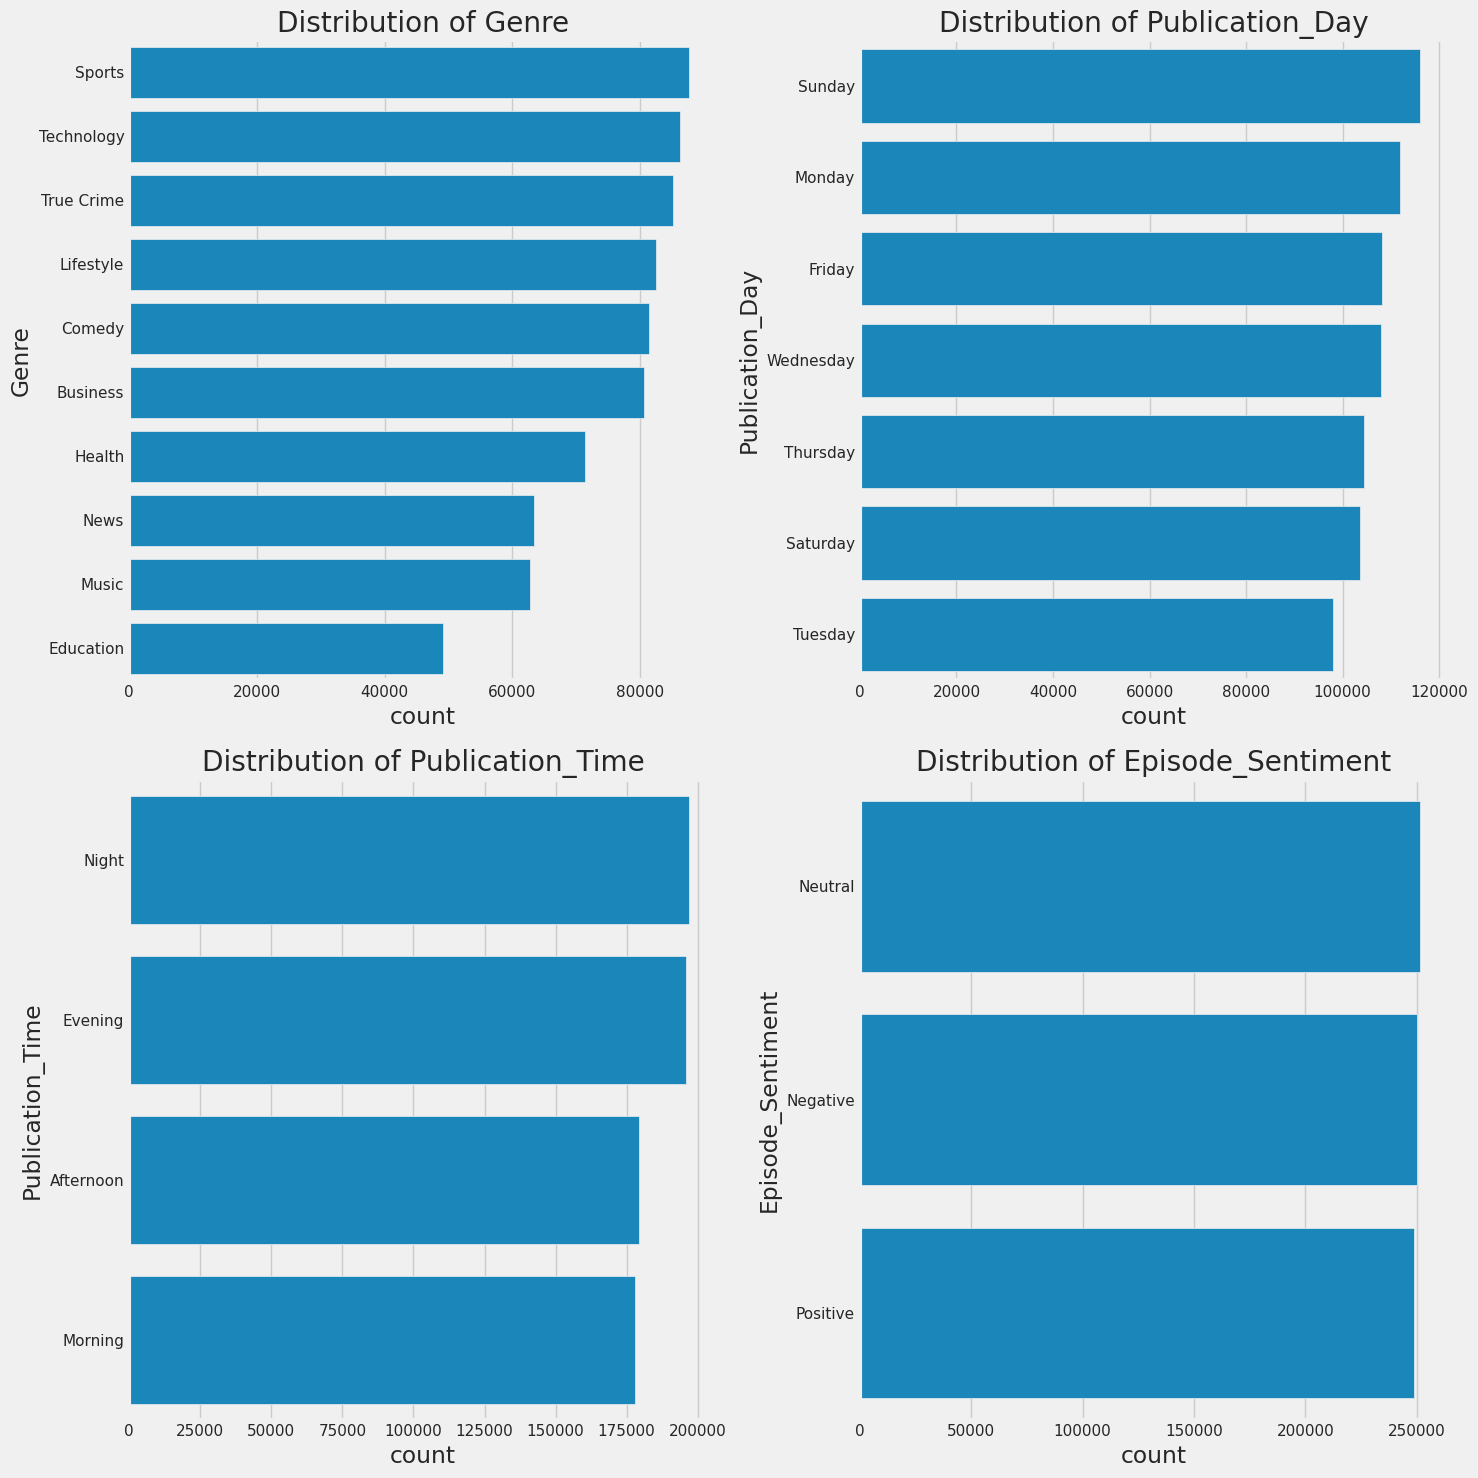

In [16]:
# Count plots for categorical variables
fig = plt.figure(figsize=(15, 15))

for i, col in enumerate(['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']):
    plt.subplot(2, 2, i+1)
    sns.countplot(y=col, data=train, order=train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()

### 4.3 Feature Analysis - Numerical Variables

In [17]:
# Identify numerical columns (excluding id and target)
numerical_cols = [col for col in train.columns if train[col].dtype != 'object' 
                  and col not in ['id', 'Listening_Time_minutes']]
print(f"Numerical columns: {numerical_cols}")

Numerical columns: ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Number_of_Ads']


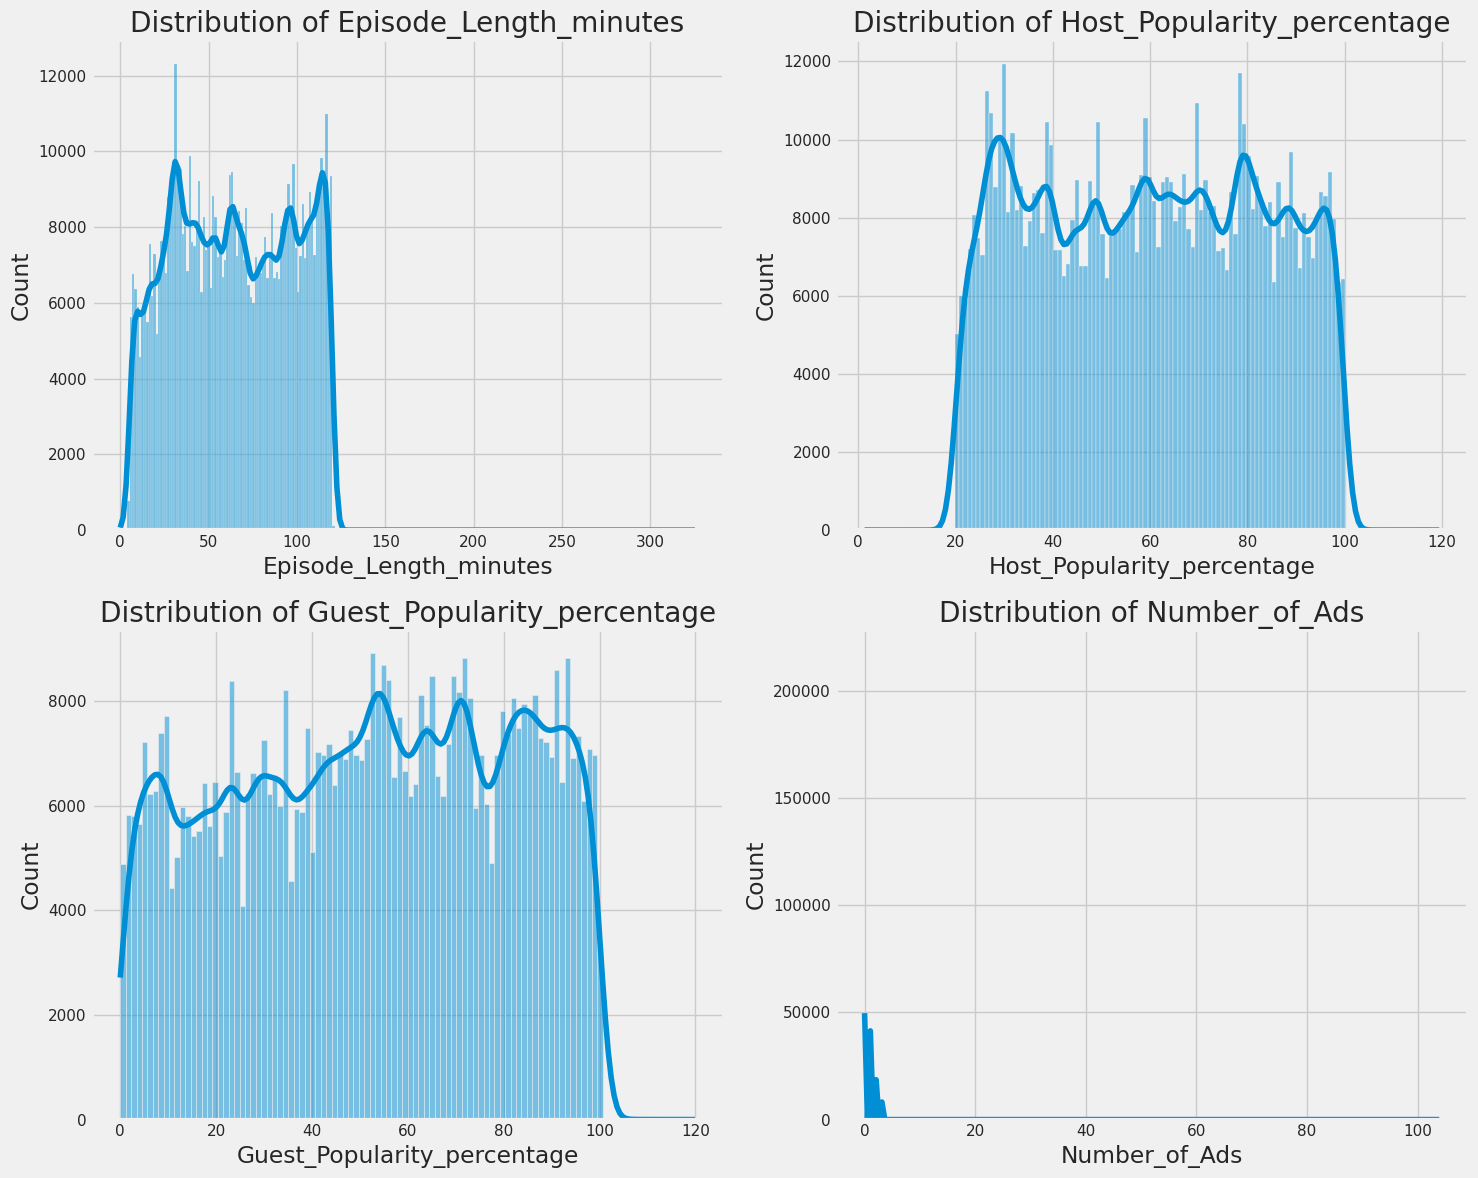

In [18]:
# Distribution of numerical features
fig = plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(train[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

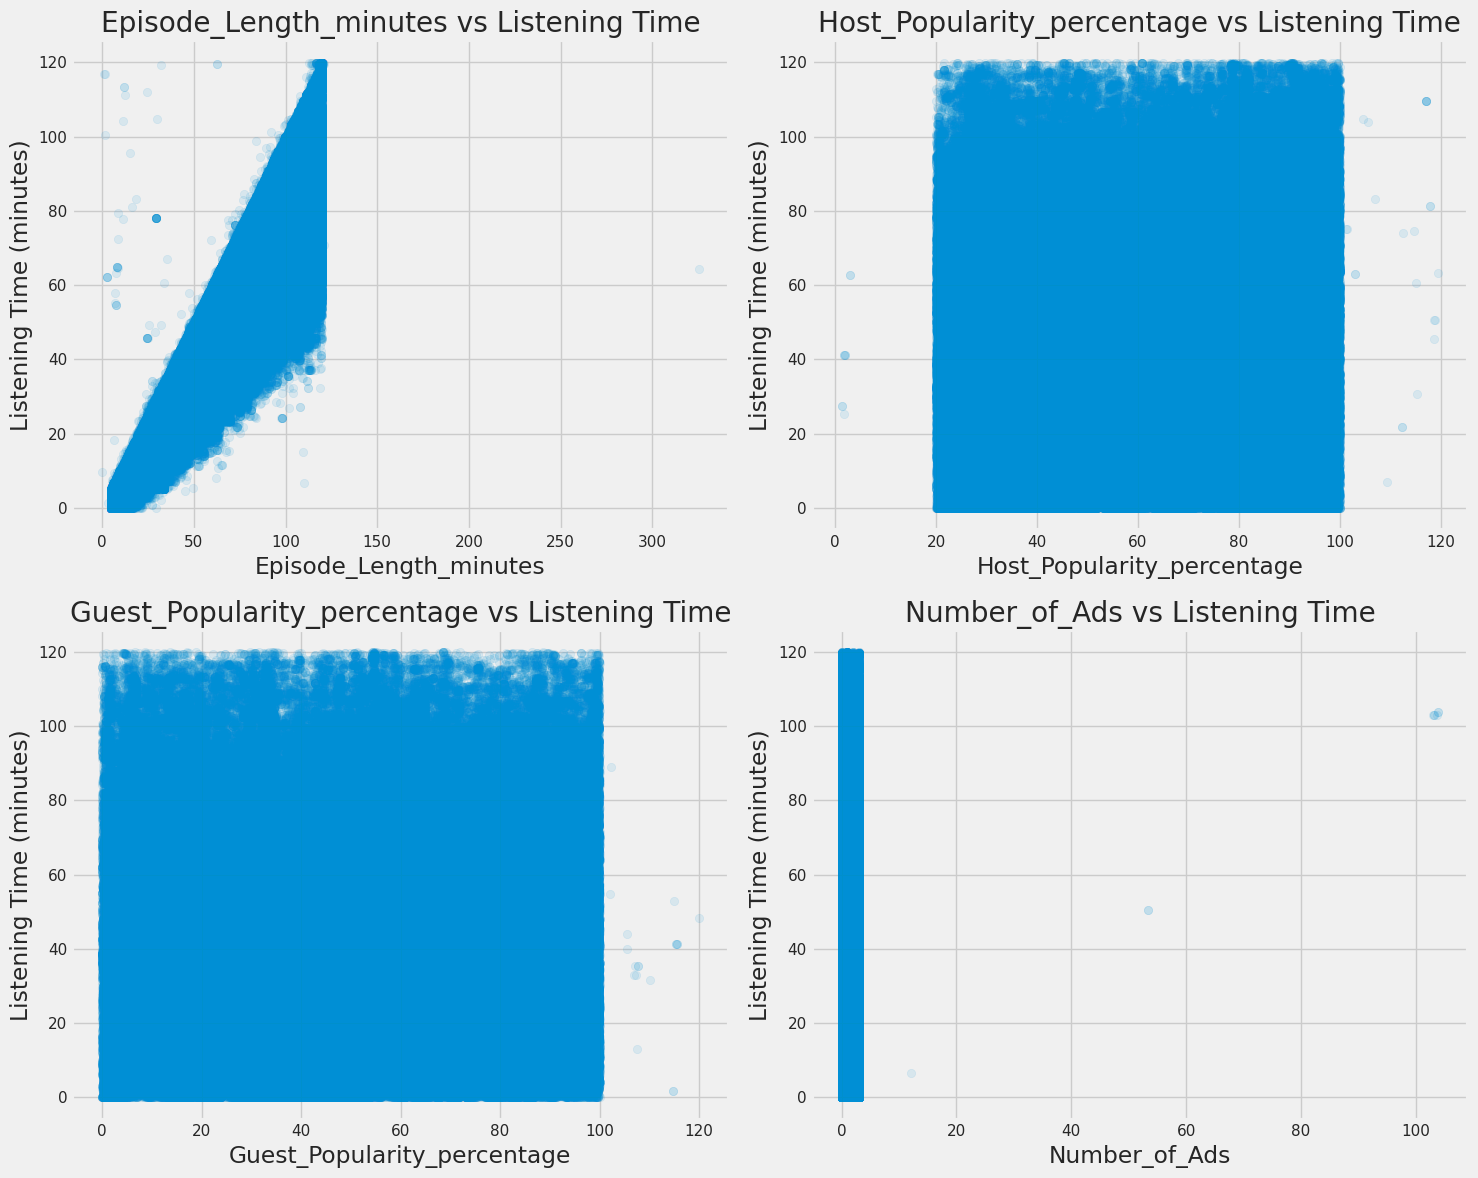

In [19]:
# Scatter plots of numerical features vs target
fig = plt.figure(figsize=(15, 12))

for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i+1)
    plt.scatter(train[col], train['Listening_Time_minutes'], alpha=0.1)
    plt.title(f'{col} vs Listening Time')
    plt.xlabel(col)
    plt.ylabel('Listening Time (minutes)')
    
plt.tight_layout()
plt.show()

In [20]:
# Correlation between numerical features and target
numerical_data = train[numerical_cols + ['Listening_Time_minutes']].copy()

# Calculate correlation matrix
correlation_matrix = numerical_data.corr()
print("Correlation with target variable:")
print(correlation_matrix['Listening_Time_minutes'].sort_values(ascending=False))

Correlation with target variable:
Listening_Time_minutes         1.000000
Episode_Length_minutes         0.916749
Host_Popularity_percentage     0.050870
Guest_Popularity_percentage   -0.016014
Number_of_Ads                 -0.118337
Name: Listening_Time_minutes, dtype: float64


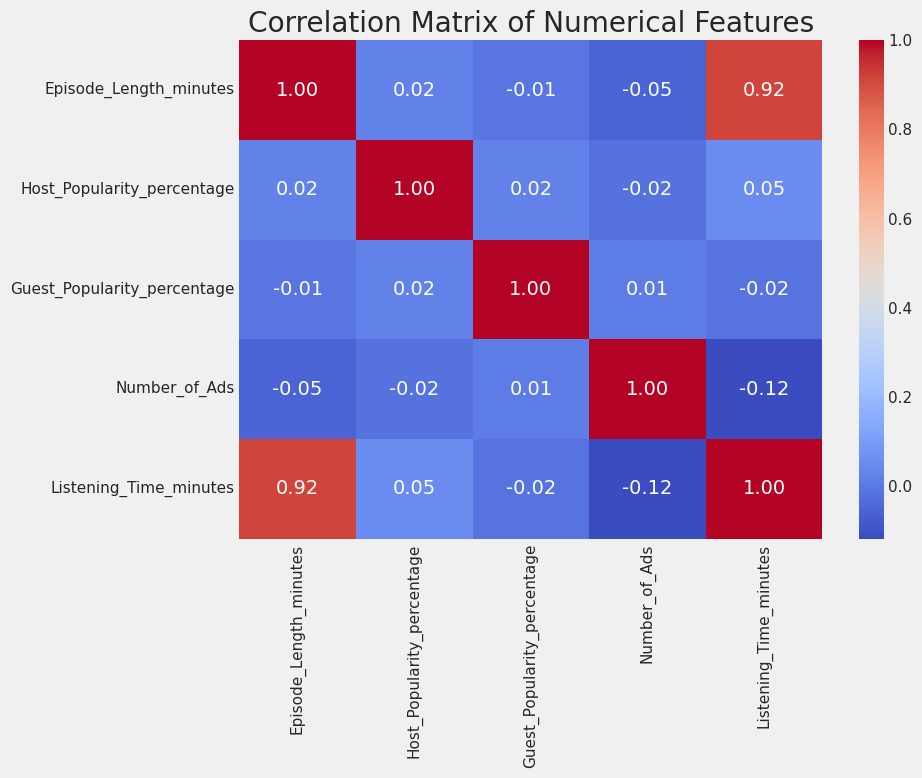

In [21]:
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

### 4.4 Relationship Analysis - Episode Length vs Listening Time

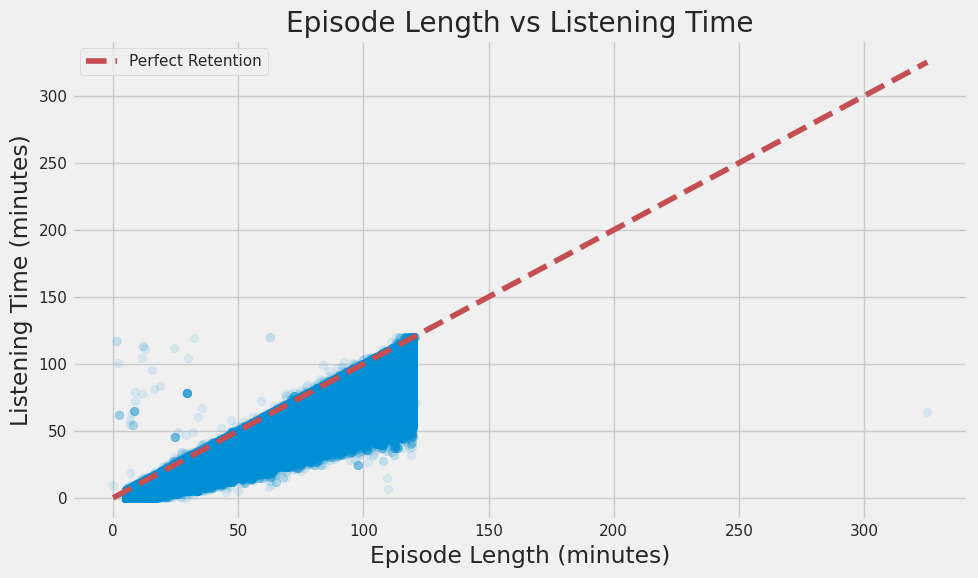

In [22]:
# Analyze relationship between episode length and listening time
plt.figure(figsize=(10, 6))
plt.scatter(train['Episode_Length_minutes'], train['Listening_Time_minutes'], alpha=0.1)
plt.title('Episode Length vs Listening Time')
plt.xlabel('Episode Length (minutes)')
plt.ylabel('Listening Time (minutes)')

# Add a line where x=y (perfect retention)
max_val = max(train['Episode_Length_minutes'].max(), train['Listening_Time_minutes'].max())
plt.plot([0, max_val], [0, max_val], 'r--', label='Perfect Retention')
plt.legend()
plt.tight_layout()
plt.show()

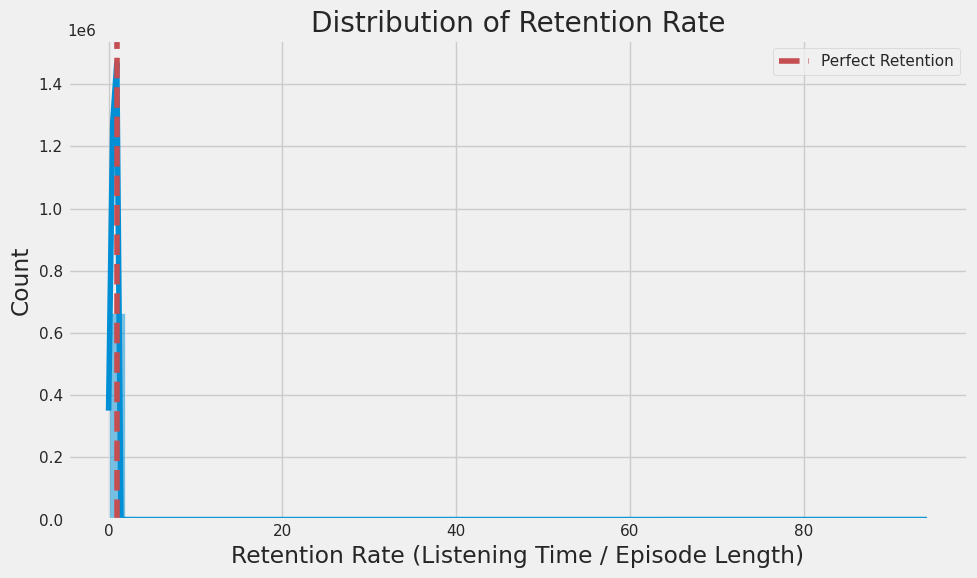

count    6.629070e+05
mean              inf
std               NaN
min      0.000000e+00
25%      5.662961e-01
50%      6.983871e-01
75%      8.223749e-01
max               inf
Name: Retention_Rate, dtype: float64


In [23]:
# Calculate retention rate (listening time / episode length)
# Only for rows where episode length is not missing
train_with_length = train.dropna(subset=['Episode_Length_minutes']).copy()
train_with_length['Retention_Rate'] = train_with_length['Listening_Time_minutes'] / train_with_length['Episode_Length_minutes']

# Analyze retention rate distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_with_length['Retention_Rate'], bins=50, kde=True)
plt.title('Distribution of Retention Rate')
plt.xlabel('Retention Rate (Listening Time / Episode Length)')
plt.axvline(1, color='r', linestyle='--', label='Perfect Retention')
plt.legend()
plt.tight_layout()
plt.show()

print(train_with_length['Retention_Rate'].describe())

### 4.5 Advanced Analysis - Multivariate Relationships

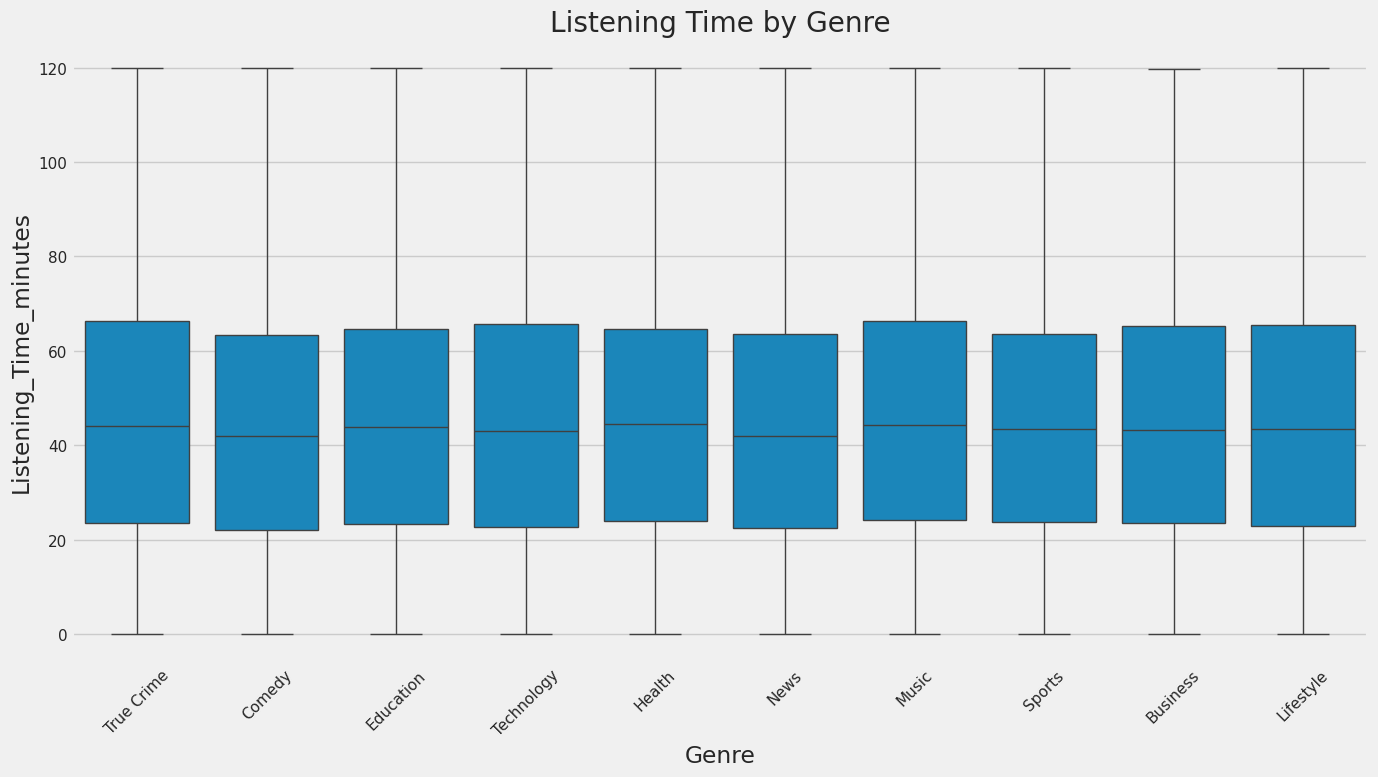

In [24]:
# Relationship between Genre, Episode Length, and Listening Time
plt.figure(figsize=(14, 8))
sns.boxplot(x='Genre', y='Listening_Time_minutes', data=train)
plt.title('Listening Time by Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

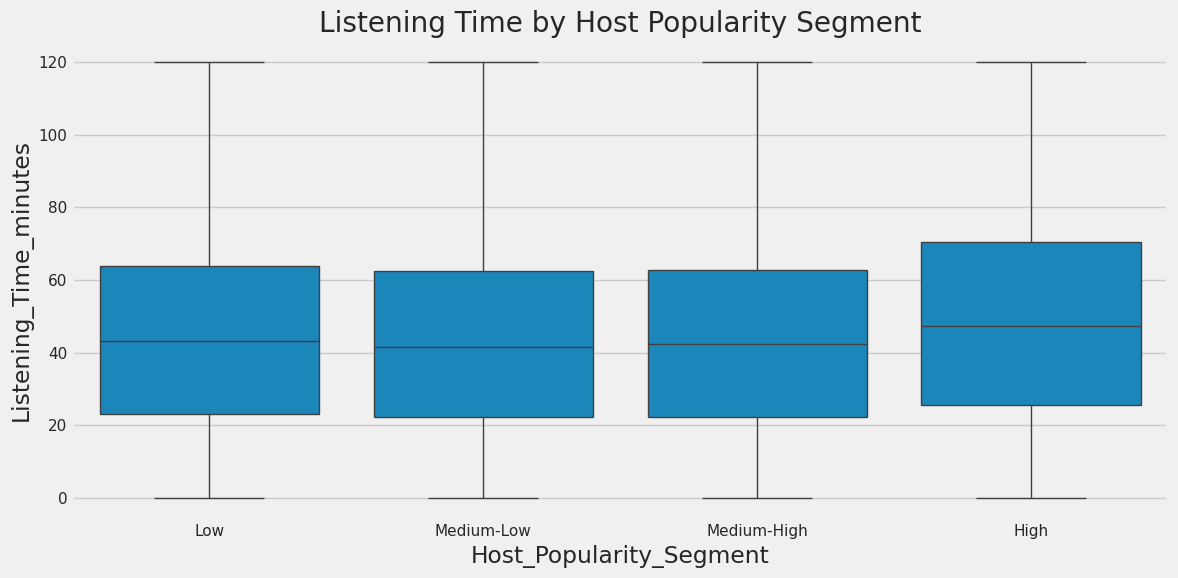

In [25]:
# Listening time by host popularity segments
train['Host_Popularity_Segment'] = pd.qcut(train['Host_Popularity_percentage'], 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='Host_Popularity_Segment', y='Listening_Time_minutes', data=train)
plt.title('Listening Time by Host Popularity Segment')
plt.tight_layout()
plt.show()

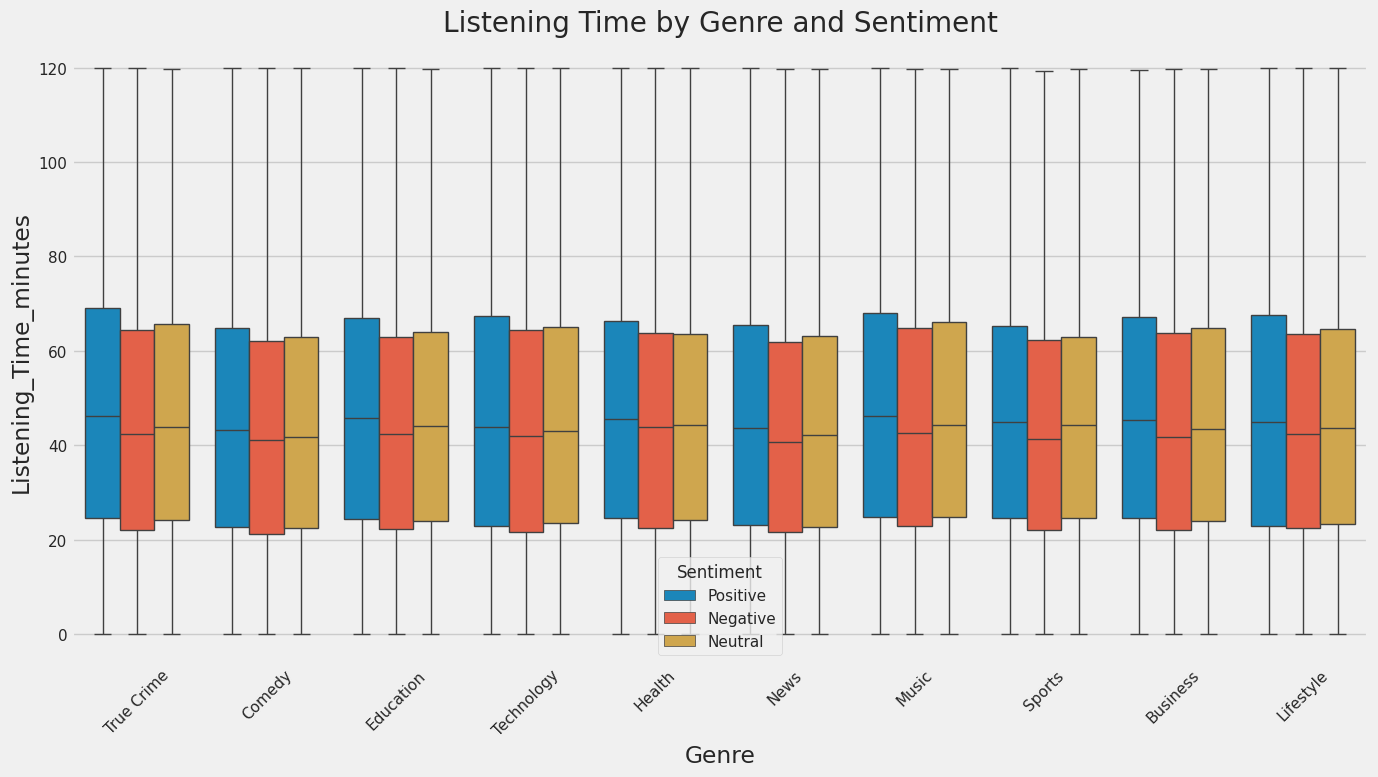

In [26]:
# Analyze how sentiment affects listening time across different genres
plt.figure(figsize=(14, 8))
sns.boxplot(x='Genre', y='Listening_Time_minutes', hue='Episode_Sentiment', data=train)
plt.title('Listening Time by Genre and Sentiment')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

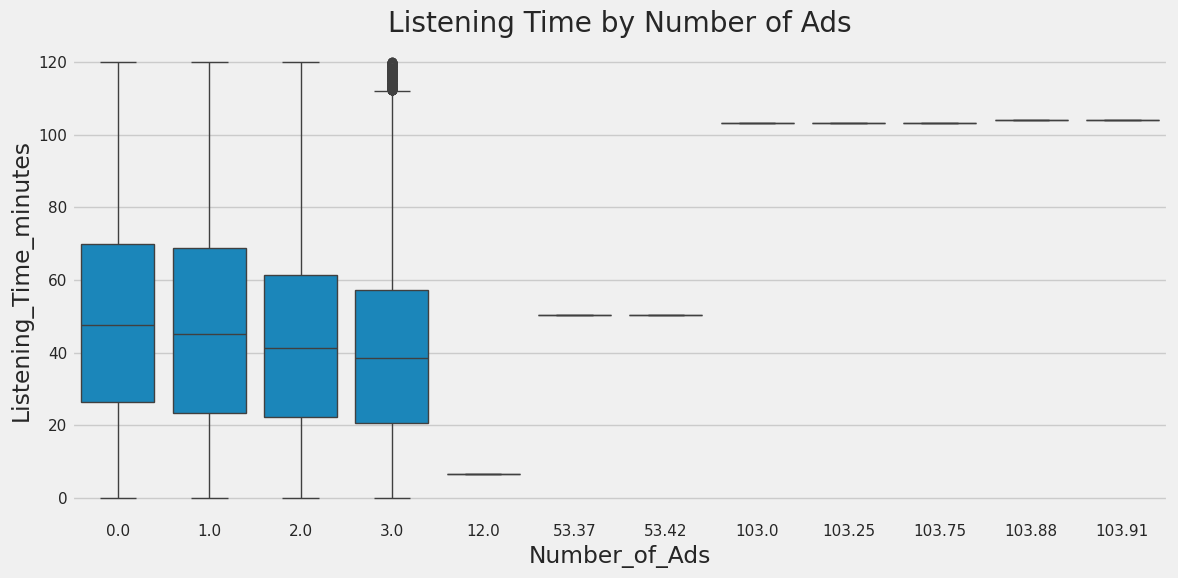

In [27]:
# Analyze effect of number of ads on listening time
plt.figure(figsize=(12, 6))
sns.boxplot(x='Number_of_Ads', y='Listening_Time_minutes', data=train)
plt.title('Listening Time by Number of Ads')
plt.tight_layout()
plt.show()

## 5. Feature Engineering

In [28]:
# Create a function for feature engineering to apply to both train and test
def engineer_features(df):
    # Create a copy to avoid changing the original dataframe
    df_new = df.copy()
    
    # Extract episode number from Episode_Title
    df_new['Episode_Number'] = df_new['Episode_Title'].str.extract(r'Episode (\d+)').astype(float)
    
    # Day of week encoding (numerical)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df_new['Day_Num'] = df_new['Publication_Day'].map({day: i for i, day in enumerate(day_order)})
    
    # Is weekend feature
    df_new['Is_Weekend'] = df_new['Publication_Day'].isin(['Saturday', 'Sunday']).astype(int)
    
    # Time of day encoding
    time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
    df_new['Time_Num'] = df_new['Publication_Time'].map({time: i for i, time in enumerate(time_order)})
    
    # For rows where Episode_Length_minutes is available, calculate proportion of listening time
    # This feature will have NaN for rows where Episode_Length_minutes is missing
    if 'Listening_Time_minutes' in df_new.columns and 'Episode_Length_minutes' in df_new.columns:
        df_new['Retention_Rate'] = df_new['Listening_Time_minutes'] / df_new['Episode_Length_minutes']
    
    # Create podcast popularity rank features
    podcast_avg_listening = df.groupby('Podcast_Name')['Listening_Time_minutes'].mean().reset_index() if 'Listening_Time_minutes' in df.columns else None
    
    if podcast_avg_listening is not None:
        podcast_avg_listening.columns = ['Podcast_Name', 'Avg_Podcast_Listening']
        df_new = df_new.merge(podcast_avg_listening, on='Podcast_Name', how='left')
    
    # Episode Sentiment encoding
    sentiment_map = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    df_new['Sentiment_Score'] = df_new['Episode_Sentiment'].map(sentiment_map)
    
    # Interaction features
    df_new['Host_Guest_Popularity_Diff'] = df_new['Host_Popularity_percentage'] - df_new['Guest_Popularity_percentage']
    df_new['Host_Guest_Popularity_Product'] = df_new['Host_Popularity_percentage'] * df_new['Guest_Popularity_percentage']
    
    return df_new

# Apply feature engineering
train_fe = engineer_features(train)
test_fe = engineer_features(test)

# Display new features
new_features = [col for col in train_fe.columns if col not in train.columns]
print(f"New features created: {new_features}")
train_fe[new_features].head()

New features created: ['Episode_Number', 'Day_Num', 'Is_Weekend', 'Time_Num', 'Retention_Rate', 'Avg_Podcast_Listening', 'Sentiment_Score', 'Host_Guest_Popularity_Diff', 'Host_Guest_Popularity_Product']


Episode_Number  Day_Num  Is_Weekend  Time_Num  Retention_Rate  \
0            98.0        3           0         3             NaN   
1            26.0        5           1         1        0.734661   
2            16.0        1           0         2        0.607920   
3            45.0        0           0         0        0.688972   
4            86.0        0           0         1        0.684194   

   Avg_Podcast_Listening  Sentiment_Score  Host_Guest_Popularity_Diff  \
0              46.018361                1                         NaN   
1              42.640909               -1                       -9.00   
2              47.047780               -1                       61.00   
3              44.769237                1                      -21.48   
4              46.840078                0                       21.39   

   Host_Guest_Popularity_Product  
0                            NaN  
1                      5084.8525  
2                       627.6309  
3                      4503.2140  
4                      4698.5076

## 6. Missing Value Treatment

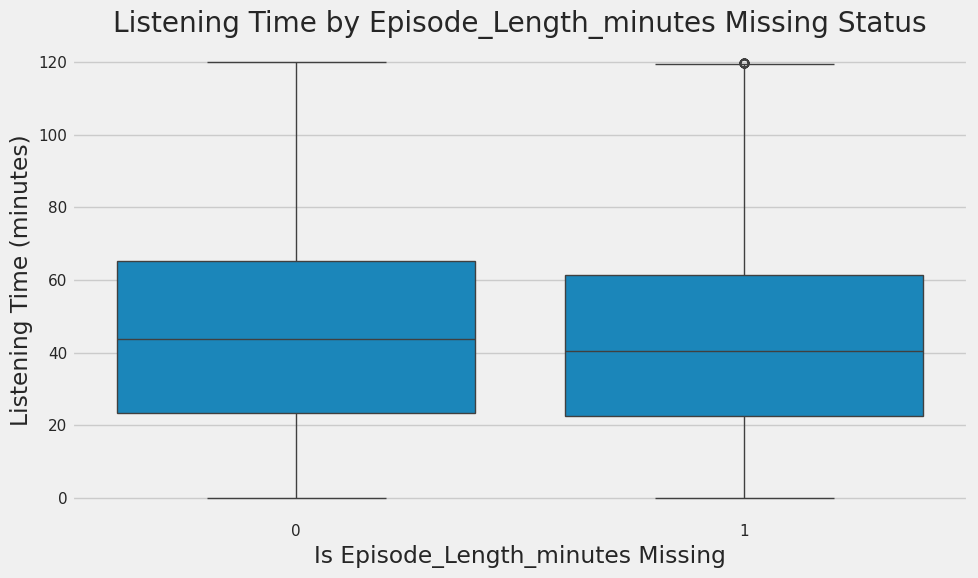

Average Listening Time by Episode_Length_minutes Missing Status:
Episode_Length_minutes_Missing
0    45.737987
1    43.149538
Name: Listening_Time_minutes, dtype: float64


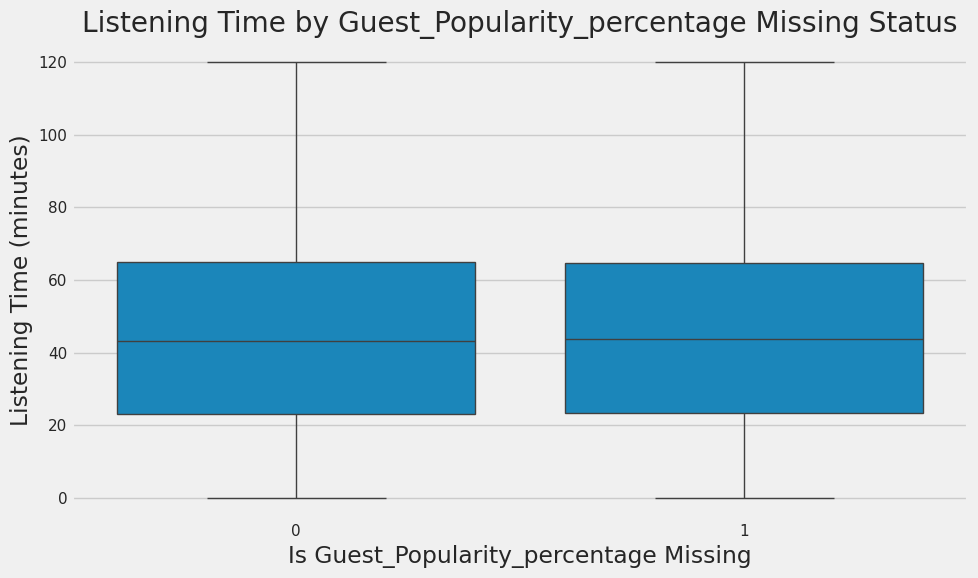

Average Listening Time by Guest_Popularity_percentage Missing Status:
Guest_Popularity_percentage_Missing
0    45.475597
1    45.279453
Name: Listening_Time_minutes, dtype: float64


In [29]:
# Analyze relationship between missing values and target
for col in ['Episode_Length_minutes', 'Guest_Popularity_percentage']:
    train_fe[f'{col}_Missing'] = train_fe[col].isnull().astype(int)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=f'{col}_Missing', y='Listening_Time_minutes', data=train_fe)
    plt.title(f'Listening Time by {col} Missing Status')
    plt.xlabel(f'Is {col} Missing')
    plt.ylabel('Listening Time (minutes)')
    plt.tight_layout()
    plt.show()
    
    # Print average listening time for missing vs non-missing
    missing_avg = train_fe.groupby(f'{col}_Missing')['Listening_Time_minutes'].mean()
    print(f"Average Listening Time by {col} Missing Status:")
    print(missing_avg)

## 7. Baseline Model Building

In [30]:
# Prepare data for modeling
# Define features to use
numerical_features = ['Episode_Length_minutes', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 
                     'Number_of_Ads', 'Episode_Number', 'Day_Num', 'Time_Num', 'Is_Weekend', 'Sentiment_Score',
                     'Host_Guest_Popularity_Diff', 'Host_Guest_Popularity_Product']

categorical_features = ['Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# Add missing indicator features
for col in ['Episode_Length_minutes', 'Guest_Popularity_percentage']:
    train_fe[f'{col}_Missing'] = train_fe[col].isnull().astype(int)
    test_fe[f'{col}_Missing'] = test_fe[col].isnull().astype(int)
    numerical_features.append(f'{col}_Missing')

# Split features and target
X = train_fe[numerical_features + categorical_features]
y = train_fe['Listening_Time_minutes']

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Prepare the test data
X_test = test_fe[numerical_features + categorical_features]

In [31]:
# Create preprocessing pipeline
# Numerical preprocessing - impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing - one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [32]:
# Create a function to evaluate different models
def evaluate_model(model_name, model, X_train, X_val, y_train, y_val):
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_val = pipeline.predict(X_val)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    train_r2 = r2_score(y_train, y_pred_train)
    val_r2 = r2_score(y_val, y_pred_val)
    
    # Print results
    print(f"{model_name} Results:")
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Validation RMSE: {val_rmse:.4f}")
    print(f"Train R²: {train_r2:.4f}")
    print(f"Validation R²: {val_r2:.4f}")
    print("-" * 50)
    
    return pipeline, val_rmse

In [33]:
# Test several baseline models
models = {
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

results = {}
best_rmse = float('inf')
best_model = None

for name, model in models.items():
    pipeline, val_rmse = evaluate_model(name, model, X_train, X_val, y_train, y_val)
    results[name] = val_rmse
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model = pipeline

Gradient Boosting Results:
Train RMSE: 13.1618
Validation RMSE: 13.1233
Train R²: 0.7648
Validation R²: 0.7659
--------------------------------------------------
XGBoost Results:
Train RMSE: 12.9970
Validation RMSE: 13.0482
Train R²: 0.7707
Validation R²: 0.7686
--------------------------------------------------
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 600000, number of used features: 37
[LightGBM] [Info] Start training from score 45.447808
LightGBM Results:
Train RMSE: 13.0102
Validation RMSE: 13.0618
Train R²: 0.7702
Validation R²: 0.7681
--------------------------------------------------


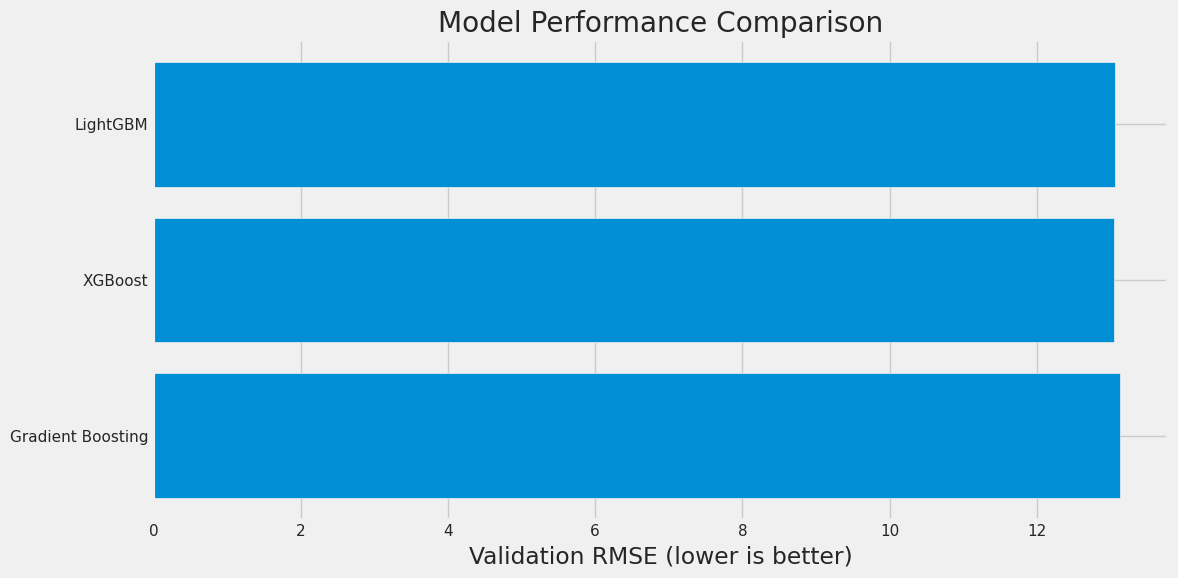

In [34]:
# Visualize model performance comparison
plt.figure(figsize=(12, 6))
plt.barh(list(results.keys()), list(results.values()))
plt.xlabel('Validation RMSE (lower is better)')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

In [35]:
# For tree-based models, analyze feature importance
# Train a simple model without the preprocessing pipeline to get feature names
# Fill missing values for this analysis
X_filled = X.copy()
for col in numerical_features:
    X_filled[col] = X_filled[col].fillna(X_filled[col].median())
    
# One-hot encode categorical features
X_filled_encoded = pd.get_dummies(X_filled, columns=categorical_features, drop_first=False)

# Train a random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_filled_encoded, y)

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': X_filled_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## 9. Make Predictions on Test Data

In [36]:
# Make predictions using the best model
test_predictions = best_model.predict(X_test)

# Create submission file
submission = pd.DataFrame({
    'id': test_fe['id'],
    'Listening_Time_minutes': test_predictions
})

# Save submission file
submission.to_csv('../Datasets/model_submission.csv', index=False)

print("Submission file created with predictions from the best model")
submission.head()

Submission file created with predictions from the best model


id  Listening_Time_minutes
0  750000               56.024071
1  750001               17.864311
2  750002               50.187317
3  750003               79.574715
4  750004               48.669277

## 10. Conclusion and Next Steps

In this notebook, we've performed a comprehensive exploratory data analysis of the Podcast Listening Time Prediction dataset and built several baseline models. Here's a summary of our findings and potential next steps:

### Key Findings:
1. The dataset contains both categorical features (Genre, Publication Day/Time, Sentiment) and numerical features (Episode Length, Host/Guest Popularity).
2. There are missing values in Episode Length and Guest Popularity that require handling.
3. We engineered several potentially useful features, such as retention rate, day/time encodings, and popularity interaction features.
4. Tree-based models (Random Forest, Gradient Boosting, XGBoost, LightGBM) generally performed better than linear models.

### Next Steps:
1. **Feature Engineering**: Create more advanced features like:
   - Podcast-level aggregates (average listening time per podcast)
   - Genre-specific features
   - More interaction terms between features

2. **Model Tuning**: Perform hyperparameter optimization for the best-performing models

3. **Ensemble Methods**: Combine predictions from multiple models

4. **Cross-Validation**: Implement k-fold cross-validation for more robust model evaluation

5. **Original Dataset**: Consider incorporating the original Podcast Listening Time dataset as mentioned in the competition description

6. **Advanced Models**: Try neural network approaches or more sophisticated algorithms

7. **Missing Value Handling**: Explore more advanced imputation techniques